In [2]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from os import listdir, path
from IPython.display import display, Markdown

# Evaluation Script
Welcome to the evaluation script. Here, you can interact with results from oxn observability experiments.

To get you started, we have prepared a few experiments:

In [3]:
display_text = ""
for experiments in listdir("experiments"):
   # read first line 
   experiment_disciption = None
   with open(path.join("experiments",experiments)) as f:
      experiment_disciption = f.readline().strip()
      experiment_disciption = experiment_disciption[1:] if experiment_disciption[0] == "#" else ""
   display_text += f" - **{experiments}** : {experiment_disciption} \n"
display(Markdown(display_text))

 - **recommendation_delay90_B.yml** :  inject a packet delay of 0-90ms while increasing sampling rate to 5% 
 - **recommendation_loss15_A.yml** :  inject packet loss of 15% while increasing the otel metric inverval to 1s 
 - **recommendation_pause_baseline.yml** :  injects a 120s pause in the recomendation service 
 - **recommendation_delay90_C.yml** :  inject a packet delay of 0-90ms while increasing sampling rate to 10% 
 - **recommendation_delay90_baseline.yml** :  inject a packet delay of 0-90ms in the recomendation service for 120s with default settings 
 - **recommendation_loss15_C.yml** :  inject packet loss of 15% while increasing sampling rate to 10% 
 - **recommendation_delay90_A.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_loss15_B.yml** :  inject packet loss of 15% while increasing sampling rate to 5% 
 - **recommendation_loss15_baseline.yml** :  inject a packet loss of 15% in the recomendation service for 120s with default settings 


You can perform any experiment using the following command:

```bash 
oxn experiments/file_from_above --report name_of_your_choice.yaml
```


# Reproduce paper figures and results

To recreate the PacketLoss results of the paper, start with the baseline experiment:
```bash
oxn experiments/recommendation_loss15_baseline.yml --report recommendation_loss15_baseline.yaml
```
then conduct experiments for the three design alternatives:
```bash
oxn experiments/recommendation_loss15_A.yml --report recommendation_loss15_A.yaml
oxn experiments/recommendation_loss15_B.yml --report recommendation_loss15_B.yaml
oxn experiments/recommendation_loss15_C.yml --report recommendation_loss15_C.yaml
```

Each experiment will run for around 10 minutes and once done will create a report which you can then review and interact with using the functions below.

In [19]:
# Import report
from gevent import monkey
monkey.patch_all()
from evaluation import Report
report = Report.from_file("recommendation_loss15_baseline.yaml")

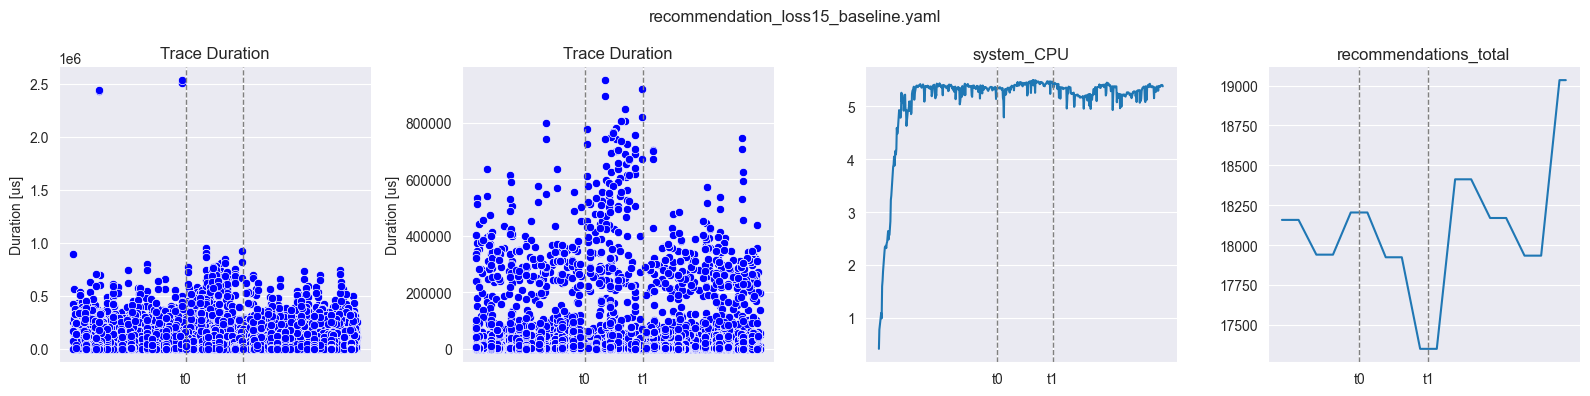

In [27]:
# Plot data for baseline from report
report.plot_interaction_grid(interactions=[0, 1, 2, 3], rows=1, cols=4)


In [6]:
# Fault visibility scores for PacketLoss treatment 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_baseline.yaml,packet_loss_treatment,PacketLossTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.561749
1,recommendation_loss15_baseline.yaml,packet_loss_treatment,PacketLossTreatment,recommendation_traces.duration,TraceResponseVariable,LR,0.806723
2,recommendation_loss15_baseline.yaml,packet_loss_treatment,PacketLossTreatment,system_CPU,MetricResponseVariable,LR,0.623333
3,recommendation_loss15_baseline.yaml,packet_loss_treatment,PacketLossTreatment,recommendations_total,MetricResponseVariable,LR,0.686957


In [7]:
#Import report for design alternative A
report = Report.from_file("recommendation_loss15_A.yaml")


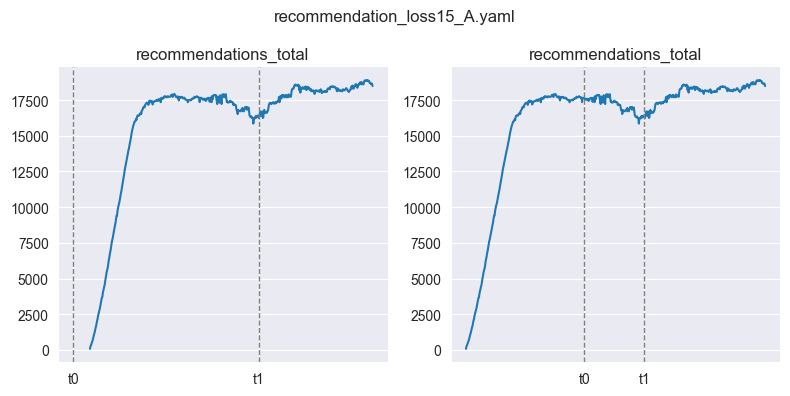

In [8]:
# Plot data for design alternative A
report.plot_interaction_grid(interactions=[1, 0], rows=1, cols=2)

In [9]:
# Fault visibility score for design alternative A 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_A.yaml,packet_loss_treatment,PacketLossTreatment,recommendations_total,MetricResponseVariable,LR,0.56993


In [10]:
#Import report for design alternative B
report = Report.from_file("recommendation_loss15_B.yaml")


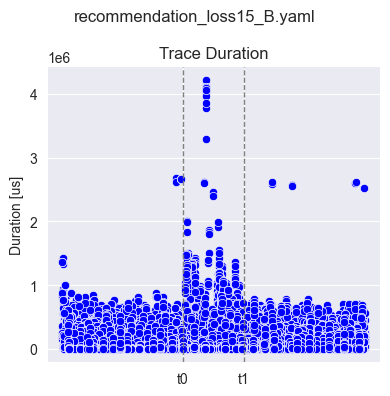

In [11]:
# Plot data for design alternative B
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [12]:
# Fault visibility scores for design alternative B 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_B.yaml,packet_loss_treatment,PacketLossTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.519164
2,recommendation_loss15_B.yaml,packet_loss_treatment,PacketLossTreatment,recommendation_traces.duration,TraceResponseVariable,LR,0.738977


In [13]:
#Import report for design alternative C
report = Report.from_file("recommendation_loss15_C.yaml")

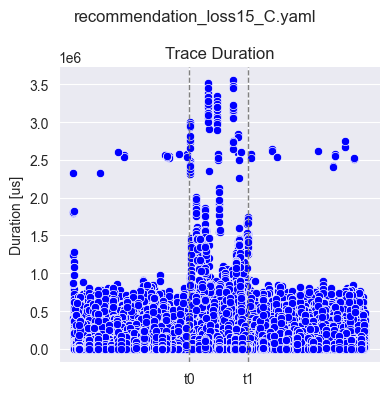

In [14]:
# Plot data for design alternative C
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [15]:
# Fault visibility scores for design alternative C 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_C.yaml,packet_loss_treatment,PacketLossTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.436572
2,recommendation_loss15_C.yaml,packet_loss_treatment,PacketLossTreatment,recommendation_traces.duration,TraceResponseVariable,LR,0.788793


In [16]:
import h5py

def get_full_names(group, parent_name=""):
    full_names = []
    for key in group.keys():
        item = group[key]
        full_name = f"{parent_name}/{key}" if parent_name else key
        if isinstance(item, h5py.Group):
            full_names.extend(get_full_names(item, parent_name=full_name))
        else:
            full_names.append(full_name)
    return full_names

# Open the HDF5 file
with h5py.File("./store.h5", "r") as file:
    # Assuming 'experiments' is the top-level group in your case
    experiments_group = file["experiments"]
    
    # Get the full names of all keys
    full_names = get_full_names(experiments_group)
    
    # Print the full names
    for name in full_names:
        print(name)

recommendation_loss15_A.yml/f5fcf694/recommendations_total/axis0
recommendation_loss15_A.yml/f5fcf694/recommendations_total/axis1
recommendation_loss15_A.yml/f5fcf694/recommendations_total/block0_items
recommendation_loss15_A.yml/f5fcf694/recommendations_total/block0_values
recommendation_loss15_A.yml/f5fcf694/recommendations_total/block1_items
recommendation_loss15_A.yml/f5fcf694/recommendations_total/block1_values
recommendation_loss15_B.yml/105fa1be/frontend_traces/axis0
recommendation_loss15_B.yml/105fa1be/frontend_traces/axis1
recommendation_loss15_B.yml/105fa1be/frontend_traces/block0_items
recommendation_loss15_B.yml/105fa1be/frontend_traces/block0_values
recommendation_loss15_B.yml/105fa1be/frontend_traces/block1_items
recommendation_loss15_B.yml/105fa1be/frontend_traces/block1_values
recommendation_loss15_B.yml/105fa1be/recommendation_traces/axis0
recommendation_loss15_B.yml/105fa1be/recommendation_traces/axis1
recommendation_loss15_B.yml/105fa1be/recommendation_traces/block0_

In [17]:
pd.read_hdf("./store.h5", key="experiments/recommendation_loss15_baseline.yml/b9ad9508/system_CPU")

,timestamp,"sum(rate(container_cpu_usage_seconds_total{container_label_com_docker_compose_project=""opentelemetry-demo""}[1m]))",system_CPU,packet_loss_treatment
timestamp,,,,
2024-02-28 06:18:22.960000038+00:00,1.709101e+09,0.410601,0.410601,NoTreatment
2024-02-28 06:18:23.960000038+00:00,1.709101e+09,0.773928,0.773928,NoTreatment
2024-02-28 06:18:24.960000038+00:00,1.709101e+09,0.848618,0.848618,NoTreatment
2024-02-28 06:18:25.960000038+00:00,1.709101e+09,0.930358,0.930358,NoTreatment
2024-02-28 06:18:26.960000038+00:00,1.709101e+09,1.005601,1.005601,NoTreatment
...,...,...,...,...
2024-02-28 06:28:36.960000038+00:00,1.709102e+09,5.400917,5.400917,NoTreatment
2024-02-28 06:28:37.960000038+00:00,1.709102e+09,5.401782,5.401782,NoTreatment
2024-02-28 06:28:38.960000038+00:00,1.709102e+09,5.405560,5.405560,NoTreatment
